# Misc

In [ ]:
# changing theme
# !jt -t chesterish 
# !jt -t onedork -fs 100 -altp -tfs 14 -nfs 115 -T
# restore default theme
!jt -r

# Comparing fake and real faces

In [ ]:
import sys 
sys.path.append(r'C:\Users\Jonas\PycharmProjects\IlkinThesis\ThesisExperiments')
from IPython.display import Image, Video

import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

import config
import cleaning_with_face_recognition as rec

## Helper classes & functions

In [ ]:
class Face:
    def __init__(self, path):
        self.face = cv2.imread(path)
    
    def __sub__(self, other):
        diff = abs(self.face.astype('int') - other.face.astype('int'))
        return diff
    
    def get(self, type='rgb'):
        if type == 'bgr':
            return self.face
        elif type == 'rgb':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2RGB)
        elif type == 'gray':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2GRAY)

In [ ]:
class Loader:
    def __init__(self, path):
        self.path = path
        self.names = glob.glob(path + '/*')
        
    def __getitem__(self, idx):
        return self.names[idx]
    
    def __len__(self):
        return len(self.names)

In [ ]:
class Metadata:
    def __init__(self):
        self.metadata = pd.read_json(config.METADATA_PATH).T
    
    def __getitem__(self, name):
        if name not in self.metadata.index:
            return None, None
        return self.metadata.loc[name][['label','original']].values
    
    def fakes(self, original = None):
        fakes = self.metadata[self.metadata['label'] == 'FAKE'] 
        if original is not None:
            return fakes[fakes['original'] == original]
        return fakes
    
    def reals(self):
        return self.metadata[self.metadata['label'] == 'REAL']
    

In [ ]:
def display_images(images, cols = 5, titles=None, figsize=(64, 16)):
    plt.figure(figsize=figsize)
    rows = len(images) // cols + 1
    
    if titles is None:
        titles = ['']*len(images)
        
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.title(title)
        plt.imshow(img)     
        
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        plt.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off

## Initializing  

In [ ]:
metadata = Metadata()

# zlukluvcyp.mp4 37 sccqbzyikm.mp4
# ---
fake_name = 'zlukluvcyp.mp4'
real_name = metadata[fake_name][1]
fake_path = os.path.join(config.FACE_IMAGES, fake_name)
real_path = os.path.join(config.FACE_IMAGES, real_name)

fakes = Loader(fake_path)
reals = Loader(real_path)

# --- 
idx = 6
f1 = Face(fakes[idx])
f2 = Face(reals[idx])
print(f'FAKE\tREAL\tDIFF, {np.sum(f1-f2)}')
display_images([f1.get('rgb'), f2.get('rgb'), (f1-f2).astype('uint8')], 3)

## Clustering with face recognition + face diff

**Steps**
1. Extract encoding for real and fake
2. Cluster real and fake seperately
3. Relate clusters
4. Diff clusters

In [ ]:
real_encodings = [rec.get_encoding(r) for r in reals]
real_clusters = AgglomerativeClustering(n_clusters=None, distance_threshold=0.55, linkage='average').fit(real_encodings)

In [ ]:
def cluster_imgs(real_clusters):
    clustered_images = {}
    for label, p in zip(real_clusters.labels_, reals):
        if clustered_images.get(label, None) is None:
            clustered_images[label] = []

        clustered_images[label].append(Face(p))

    clustered_fake_images = {}
    for label, p in zip(real_clusters.labels_, fakes):
        if clustered_fake_images.get(label, None) is None:
            clustered_fake_images[label] = []

        clustered_fake_images[label].append(Face(p))
    
    return clustered_images, clustered_fake_images

In [ ]:
clustered_images, clustered_fake_images = cluster_imgs(real_clusters)

In [ ]:
plt.figure(figsize=(16, 8))
for cluster, imgs in clustered_images.items():
    fake_imgs = clustered_fake_images[cluster]
    difs = [np.sum(r_img - f_img) for r_img, f_img in zip(imgs, fake_imgs)]
    plt.plot(difs, label=cluster, marker='o')
    
plt.legend()
plt.title(f'Difference between cluster images fake: {fake_name} real: {real_name}')
plt.savefig(f'outputs/img_dif_{fake_name}-{real_name}.jpg')
print(fake_name, real_name)

In [ ]:
def show_clustered_imgs(clustered_images, clustered_fake_images):
    for cluster, imgs in clustered_images.items():
        print(cluster)
        display_images([i for i in imgs], 18)
        display_images([i for i in clustered_fake_images[cluster]], 18)

In [ ]:
diffs = []
for cluster, imgs in clustered_images.items():
    print(f'{cluster}: {len(imgs)}')

show_clustered_imgs(clustered_images, clustered_fake_images)

In [ ]:
# adrcjenxlz.mp4 - bad example, keep to display
# xifuovpydw.mp4

### Distance between face encodings

In [ ]:
for i, (f, r) in enumerate(zip(fake_clusters, real_clusters)):
    fake_encoding = rec.get_encoding(f)
    real_encoding = rec.get_encoding(r)
    distance = np.linalg.norm(fake_encoding - real_encoding)
    
    img1 = cv2.imread(f)
    img2 = cv2.imread(f)
    cv2.imwrite(f'test/{i}_{distance}.jpg', np.hstack((img1, img2)))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
fake_encoding = rec.get_encoding(fakes[0])
real_encoding = rec.get_encoding(reals[0])

plt.scatter(np.arange(len(fake_encoding)), fake_encoding)
plt.scatter(np.arange(len(real_encoding)), real_encoding)

## (Deprecated) Plotting face difference between fake and real

In [ ]:
diff_fakes = []
diff_reals = []
diff_other = []

for f, r in zip(fakes, reals):
    assert f.split('mp4_')[-1] == r.split('mp4_')[-1], f'Fake: {f}, real: {r}'
        
    fake_face = Face(f)
    real_face = Face(r)
    diff = np.sum((fake_face - real_face).astype('int')) 
    
    identifier = f.split('_')[-1]
    if identifier == '0.jpg':
        diff_reals.append(diff)
        
    elif identifier == '1.jpg':
        diff_fakes.append(diff)
    else:
        diff_other.append(diff)

plt.figure(figsize=(16,8))
plt.plot(diff_reals, label='0')
plt.plot(diff_fakes, label='1')
plt.plot(diff_other, label='other')
plt.legend()

## Analyzing face position data

In [ ]:
from utils import get_frames


class VideoReader:
    def __init__(self, name):
        self.name = name
        self.path = os.path.join(os.path.dirname(config.VIDEO_PATH), name)
        self.label = metadata[name][0]
        self.original = metadata[name][1]
        self.frames = get_frames(self.path)
        self.face_centers = []
        self.cluster_labels = None

        if self.label == 'REAL':
            self.coordinates = face_coordinates.loc[name].values
        else:
            self.coordinates = face_coordinates.loc[self.original].values

    def __get__(self, frame_id):
        return self.coordinates[frame_id]

    def get_face(self, frame_id, face_id=None):
        faces = []
        for i, c in enumerate(self.coordinates[frame_id]):
            if face_id is not None and i != face_id:
                continue
            faces.append(self.frames[frame_id].crop(c))
        return faces

    def get_all_faces(self):
        faces = []

        for i, frame in enumerate(self.coordinates):
            for face in frame:
                faces.append(self.frames[i].crop(face))
        return faces

    def calculate_face_centers(self):
        for frame in self.coordinates:
            for face in frame:
                self.face_centers.append([(face[0] + face[2]) / 2,
                                          (face[1] + face[3]) / 2])

    def _cluster(self, threshold=150, linkage='average'):
        self.cluster_labels = AgglomerativeClustering(
            n_clusters=None, distance_threshold=threshold,
            linkage=linkage).fit(self.face_centers).labels_

    # TODO: Add label option for fake videos
    def cluster_faces(self, labels=None):

        clusters = {}

        if labels is not None:
            self.cluster_labels = labels
        else:
            self.calculate_face_centers()
            self._cluster()

        faces = self.get_all_faces()

        for label, face in zip(self.cluster_labels, faces):
            if clusters.get(label, None) is None:
                clusters[label] = []
            clusters[label].append(face)
        return clusters

    def play(self):
        return Video(self.path, embed=True, width=640)

In [ ]:
metadata = Metadata()
face_coordinates = pd.read_json(config.FACE_COORDINATES_PATH).T

fake_name = 'qvgutokvct.mp4'
real_name = metadata[fake_name][1]

In [ ]:
fake_video = VideoReader(fake_name)
# real_video = VideoReader(real_name)
fake_video.play()

### Cluster and display

In [ ]:
def diff(im1, im2):
    w, h  = im1.size
    diff_img = np.abs(np.array(im1, dtype='int') - np.array(im2, dtype='int'))
    value = np.sum(diff_img) / (w*h*3)
    
    return diff_img.astype('uint8'), value

In [ ]:
fake_video = VideoReader(fake_name)
real_video = VideoReader(fake_name)
real_clusters = real_video.cluster_faces()
fake_clusters = fake_video.cluster_faces(real_video.cluster_labels)

cols = max([len(l) for l in real_clusters.values()])

diff_imgs = {}
diff_values = {}

# getting difference image and value between real and fake faces
for k, _reals in real_clusters.items():
    if diff_imgs.get(k, None) is None:
        diff_imgs[k] = []   
        diff_values[k] = []
    _fakes = fake_clusters[k]
    
    for i, r in enumerate(_reals):
        f = _fakes[i]
        diff_img, diff_value = diff(r, f)
        diff_imgs[k].append(diff_img)
        diff_values[k].append(diff_value)

# displaying real and fake images with difference
for k, v in real_clusters.items():
    print(k)
    display_images(v, cols=cols)
    display_images(fake_clusters[k], cols=cols)
    display_images(diff_imgs[k], cols=cols)

In [ ]:
# plotting difference graphic
plt.figure(figsize=(16,8))
for k, v in diff_values.items():
    plt.plot(v, label=k, marker='x')
    
plt.legend()
plt.show()

# Comparing cleaned faces with dirty

## Analyzing dirty set

In [ ]:
# Number of faces detected in each frame of each video
face_coordinates = pd.read_json('data/face_coordinates_48_higher_th.json').T
import math
from collections import Counter
total = 0
for idx, item in face_coordinates.iterrows():
    try:
        size = [len(i) for i in item if i is not None]
        total += sum(size)
        print(f'{idx} : min: {min(size)} max: {max(size)} total: {sum(size)} dist: {Counter(size)}')
    except:
        print(f'Problem with {idx}')

In [ ]:
total

## Analyzing cleaned set

In [ ]:
cleaned_fc = pd.read_json('data/cleaned_faces_48_higher_th.json').T
cleaned_fc

In [ ]:
# Video with no faces detected after cleaning
cleaned_fc[cleaned_fc.isnull().all(1)]

In [ ]:
cluster_counts = cleaned_fc.notnull().sum(axis=1)
print(np.histogram(cluster_counts, bins=[0,1,2,3,4,5])[0])
cluster_counts.hist(bins=[0,1,2,3,4,5])

In [ ]:
cleaned_fc[cluster_counts == 1].index

In [ ]:
video = VideoReader('djodnxisaa.mp4')
video.play()

In [ ]:
# displaying images
imgs = []
names = []

for name in cleaned_fc[cluster_counts == 1].index:
    video = VideoReader(name)
    imgs.append(video.frames[0])
    names.append(name)

In [ ]:
display_images(imgs, cols=1, titles=names, figsize=(24,64))

## Summary

422 original videos were processed from batch 48.

**Note:** No face detected in video bwhdmdqwba.mp4

###  Experiment 1
 - **Setup** 
      - Detector: This detector detected 7531 faces in 421 videos, expected : 6752 in 422
     ```
     mtcnn = MTCNN(image_size=300, margin=20, keep_all=True, min_face_size=60, 
                     thresholds=[0.6, 0.7, 0.7], post_process=False, device='cuda:0')
     ```
     - Clustering linkage: 'average', threshold: 100, data: face_center
 - **Rules** If single cluster then keep; if more than one cluster remove clusters with less than 10 items
 - **Results**: No face in 2 videos, single face in 381 videos and 2 faces in 39 videos. 
     - Videos with no face: jilfwcuyrp.mp4, bwhdmdqwba.mp4
 - **Video Analysis** 
     - jilfwcuyrp.mp4: 16 faces detected but clustered into multiple due to fast movement of the actor
     - xjinzawywt.mp4: Single character multiple clusters
     
     videos with 2 characters detected:
     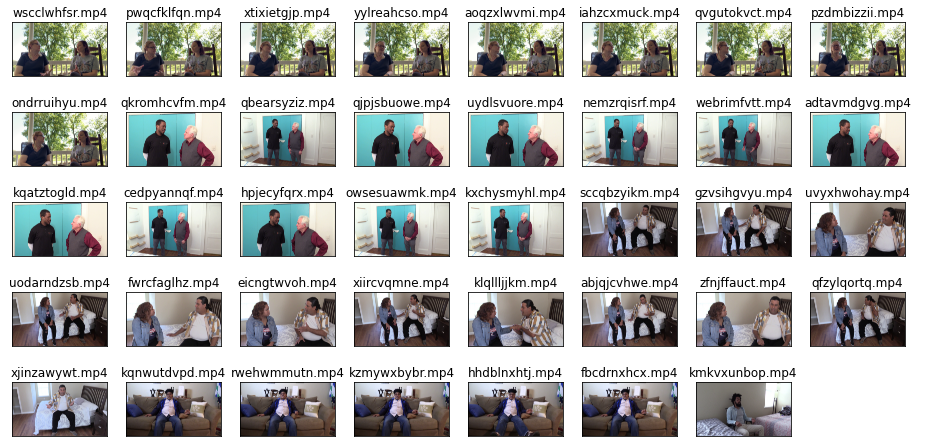
     
### Experiment 2
 - **Setup** 
     - Detector: This detector detected 7124 faces in 418 videos, expected : 6752 in 422
     ```
     mtcnn = MTCNN(image_size=300, margin=20, keep_all=True, min_face_size=60, 
                     thresholds=[0.85, 0.95, 0.95], post_process=False, device='cuda:0')
     ```
     - Clustering linkage: 'average', threshold: 100, data: face_center
 - **Rules** - Same with previous
 - **Results**: No face in 4 videos, single face in 386 videos and 2 faces in 32 videos. False detections decreased at the same time more faces missed. Videos with no face detected: sudzolvppu.mp4, uhyizbpmzk.mp4, jilfwcuyrp.mp4, bwhdmdqwba.mp4
 

# Possible cases


1. Single cluster
     1. single face - keep all
     2. multiple faces 
     3. single face & non-face
    
    
4. Multiple clusters
    1. Single face divided
    2. Single face cluster majority + artifact - keep majority
    3. Single face cluster + equally big artifact 
    4. Same length face clusters
    5. 2 same length face clusters + smaller artifact cluster
